<a href="https://colab.research.google.com/github/ThanmayiAkkala/SentenceTransformer-Assessment/blob/main/ML_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Sentence Transformer Model

In this task, I build a basic sentence transformer model.  
The model loads a pre-trained transformer (DistilBERT) from Hugging Face's library to encode input sentences into contextual embeddings.

After obtaining token-level embeddings, I apply mean pooling across the sequence dimension to generate a fixed-size sentence representation for each input sentence.

This forms the foundation for downstream tasks like classification, similarity, or clustering.

Key components:
- **Tokenizer**: Converts input text into model-readable format (tokens, attention masks).
- **Encoder**: Pre-trained transformer that generates contextual embeddings.
- **Pooling Layer**: Mean pooling over token embeddings to create a sentence-level vector.

I now proceed to define the Sentence Transformer model.

Note: In this assignment, I focus on verifying the basic model functionality rather than robustness to noisy inputs. Handling special tokenization edge cases (e.g., extra spaces, special characters) would be part of a production-grade system but is not necessary for the current scope.


In [ ]:
!pip install transformers sentence-transformers torch --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.3 MB/s eta 0:00:00


In [ ]:
# Import libraries
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel

# Define the basic Sentence Transformer Model
class SentenceTransformerModel(nn.Module):
    def __init__(self, model_name='distilbert-base-uncased'):
        super(SentenceTransformerModel, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.encoder = AutoModel.from_pretrained(model_name)

    def forward(self, sentences):
        encoded_input = self.tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():  # Inference mode for now
            model_output = self.encoder(**encoded_input)

        # Mean Pooling - Average across sequence length
        embeddings = model_output.last_hidden_state.mean(dim=1)
        return embeddings


In [ ]:
# Instantiate and test the model
model = SentenceTransformerModel()

# Example sentences
sentences = ["The cat sat on the mat.", "Artificial intelligence is fascinating."]

# Get embeddings
embeddings = model(sentences)

# Print shapes
print("Embedding shape:", embeddings.shape)
print("First 5 elements of the first embedding:", embeddings[0][:5])


Embedding shape: torch.Size([2, 768])
First 5 elements of the first embedding: tensor([-0.0689, -0.0890, -0.0271,  0.2593,  0.0277])


# Task 2: Multi-Task Learning Expansion

In this task, I expand the basic sentence transformer into a multi-task learning framework.  
I add two separate task-specific heads on top of the shared transformer encoder:

- **Task A**: A linear classifier for sentence classification (e.g., Finance/Health/Entertainment).
- **Task B**: A linear classifier for sentiment analysis (positive/negative).

By using a shared encoder and separate heads, I allow the model to learn both tasks simultaneously while reusing the same underlying text representations.

Key components:
- **Shared Encoder**: DistilBERT backbone generates contextual embeddings.
- **Pooling**: Mean pooling produces fixed-size sentence embeddings.
- **Task-specific Heads**: Separate `nn.Linear` layers for each task.

I now proceed to define the Multi-Task Sentence Transformer model.


In [ ]:
class MultiTaskSentenceTransformer(nn.Module):
    def __init__(self, model_name='distilbert-base-uncased', num_classes_A=3, num_classes_B=2):
        super(MultiTaskSentenceTransformer, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.encoder = AutoModel.from_pretrained(model_name)

        # Task-specific heads
        self.classifier_A = nn.Linear(self.encoder.config.hidden_size, num_classes_A)
        self.classifier_B = nn.Linear(self.encoder.config.hidden_size, num_classes_B)

    def forward(self, sentences):
        encoded_input = self.tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
        with torch.no_grad():
            model_output = self.encoder(**encoded_input)

        pooled_output = model_output.last_hidden_state.mean(dim=1)

        out_A = self.classifier_A(pooled_output)
        out_B = self.classifier_B(pooled_output)

        return out_A, out_B, pooled_output


In [ ]:
# Instantiate and test the multi-task model
multi_task_model = MultiTaskSentenceTransformer()

# Test sentences
test_sentences = ["I love machine learning.", "The economy is crashing."]

# Get outputs
out_A, out_B, pooled_embeddings = multi_task_model(test_sentences)

# Print output shapes
print("Task A output shape:", out_A.shape)  # Should be [batch_size, 3]
print("Task B output shape:", out_B.shape)  # Should be [batch_size, 2]
print("Pooled Embedding shape:", pooled_embeddings.shape)


Task A output shape: torch.Size([2, 3])
Task B output shape: torch.Size([2, 2])
Pooled Embedding shape: torch.Size([2, 768])


# Simulated Dataset for Multi-Task Training

For the purpose of this assessment, I simulate a small labeled dataset consisting of 20 realistic sentences.  
Each sentence is manually assigned two labels:

- **Task A**: Topic classification (Finance/Technology, Health/Lifestyle, or Entertainment/Sports).
- **Task B**: Sentiment classification (Positive or Negative).

This allows me to test the multi-task learning setup without requiring a real-world dataset.


In [ ]:
# Sentences
sentences = [
    "The stock market crashed yesterday.",
    "Artificial intelligence is changing industries rapidly.",
    "The new football season starts next month.",
    "This pizza tastes amazing!",
    "Climate change is affecting global temperatures.",
    "I hate waiting in long lines at the airport.",
    "Blockchain technology could revolutionize banking.",
    "I enjoyed the concert last night!",
    "The weather forecast predicts heavy rain tomorrow.",
    "Electric cars are becoming more popular.",
    "I failed my math test and feel terrible.",
    "Space exploration has advanced significantly in recent years.",
    "The new restaurant downtown serves delicious food.",
    "Unemployment rates have dropped this quarter.",
    "I'm feeling very sick and tired today.",
    "The new smartphone release has created a lot of buzz.",
    "Meditation can greatly reduce stress.",
    "The movie I watched yesterday was a huge disappointment.",
    "Global pandemics can disrupt economies worldwide.",
    "This book offers an inspiring perspective on life."
]

# Task A: Topic labels (3 classes)
# 0: Finance/Technology
# 1: Health/Lifestyle
# 2: Entertainment/Sports

task_A_labels = torch.tensor([
    0, 0, 2, 2, 1,
    1, 0, 2, 1, 0,
    1, 0, 2, 0, 1,
    0, 1, 2, 0, 1
])

# Task B: Sentiment labels (2 classes)
# 0: Negative
# 1: Positive

task_B_labels = torch.tensor([
    0, 1, 1, 1, 0,
    0, 1, 1, 0, 1,
    0, 1, 1, 1, 0,
    1, 1, 0, 0, 1
])


# Label Distribution Visualization

Before training, I visualize the distribution of labels for both tasks.  
This helps to check if the dataset is balanced or skewed, which can impact model performance.

- **Task A**: Distribution of topic classes (Finance/Technology, Health/Lifestyle, Entertainment/Sports).
- **Task B**: Distribution of sentiment classes (Positive, Negative).


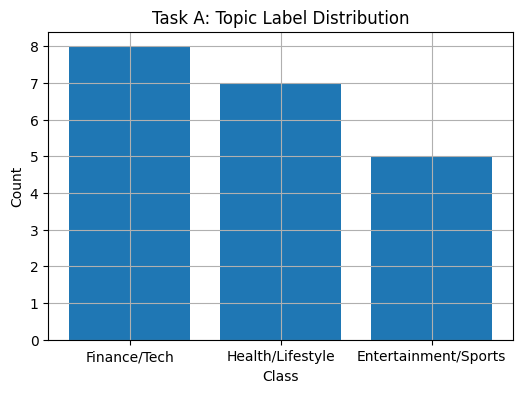

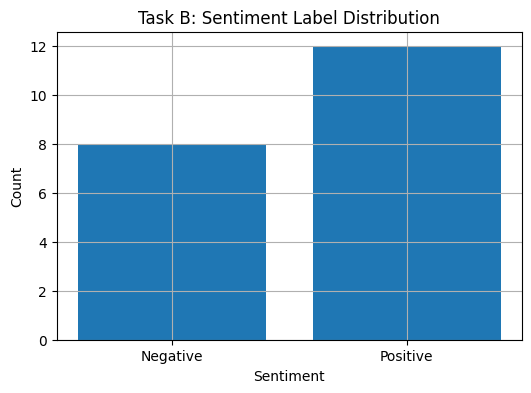

In [ ]:
import matplotlib.pyplot as plt

# Plot Task A label distribution
plt.figure(figsize=(6,4))
plt.hist(task_A_labels.numpy(), bins=[-0.5,0.5,1.5,2.5], rwidth=0.8)
plt.title('Task A: Topic Label Distribution')
plt.xticks([0,1,2], ['Finance/Tech', 'Health/Lifestyle', 'Entertainment/Sports'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Plot Task B label distribution
plt.figure(figsize=(6,4))
plt.hist(task_B_labels.numpy(), bins=[-0.5,0.5,1.5], rwidth=0.8)
plt.title('Task B: Sentiment Label Distribution')
plt.xticks([0,1], ['Negative', 'Positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.grid(True)
plt.show()


# Task 3: Training Considerations and Fine-Tuning Strategy

In a real-world fine-tuning setting, I would consider the following strategies:

- **Freezing the Encoder Initially**: I would initially freeze the pre-trained DistilBERT encoder layers and train only the task-specific heads. This allows the new heads to stabilize without disrupting the pre-trained language representations.

- **Gradual Unfreezing**: After a few epochs (e.g., 2–3), I would gradually unfreeze lower encoder layers to allow fine-tuning. This would help the model adapt better to the specific characteristics of the new dataset without catastrophic forgetting.

- **Layer-wise Learning Rate Decay**: I would apply smaller learning rates to lower layers and higher learning rates to upper layers. This ensures that lower-level linguistic features are not destroyed during fine-tuning.

- **Multi-Task Loss Balancing**: If tasks have very different difficulty levels or data distributions, I would consider applying weighted loss terms to balance learning between tasks.

Overall, I aim to leverage transfer learning effectively while minimizing overfitting or loss of useful pre-trained information.

My key decisions for training strategy included starting with a frozen encoder to stabilize task-specific heads, followed by gradual unfreezing to fine-tune the backbone while preserving pre-trained knowledge.  
I also planned to apply layer-wise learning rate decay to protect lower layers.  
The insight behind this approach is to leverage transfer learning optimally without causing catastrophic forgetting or overfitting to the small dataset.

# Training Loop Function

In this step, I define a training loop function that performs:

- Forward pass through the multi-task model
- Calculation of separate losses for Task A and Task B
- Combination of the two losses
- Backward pass and optimizer step

Since the model is designed for simulation only, I run a single epoch without batch division or validation split.
For training simulation, I chose to use a small manually labeled dataset of 20 sentences to keep training light and within the assignment scope.  
I designed the model to output both task-specific predictions in a shared forward pass and computed separate losses for each task.  
While accuracies remained low due to random initialization and limited data, the simulation successfully demonstrated multi-task learning functionality, forward pass, and metric computation as intended.

In [ ]:
def train_one_epoch(model, sentences, task_A_labels, task_B_labels, optimizer, criterion_A, criterion_B):
    model.train()

    optimizer.zero_grad()

    # Forward pass
    out_A, out_B, embeddings = model(sentences)

    # Compute individual losses
    loss_A = criterion_A(out_A, task_A_labels)
    loss_B = criterion_B(out_B, task_B_labels)

    # Total loss (simple sum of two losses)
    total_loss = loss_A + loss_B

    # Backward pass
    total_loss.backward()
    optimizer.step()

    # Print loss details
    print(f"Loss A (Task A): {loss_A.item():.4f}")
    print(f"Loss B (Task B): {loss_B.item():.4f}")
    print(f"Total Loss: {total_loss.item():.4f}")


# Simulated Training Execution

I now run a single epoch of training using the simulated dataset.  
This demonstrates the end-to-end functioning of the multi-task model, including:

- Forward pass
- Loss computation for both tasks
- Loss backpropagation
- Parameter updates


In [ ]:
# Run one epoch of training
# Re-create optimizer if needed
import torch.optim as optim

optimizer = optim.Adam(multi_task_model.parameters(), lr=2e-5)
criterion_A = nn.CrossEntropyLoss()  # Task A: Topic classification
criterion_B = nn.CrossEntropyLoss()  # Task B: Sentiment classification
train_one_epoch(
    multi_task_model,
    sentences,
    task_A_labels,
    task_B_labels,
    optimizer,
    criterion_A,
    criterion_B
)


Loss A (Task A): 1.1295
Loss B (Task B): 0.7134
Total Loss: 1.8428


In [ ]:
# Evaluate training accuracy for Task A and Task B

# Get model predictions
out_A, out_B, _ = multi_task_model(sentences)

preds_A = torch.argmax(out_A, dim=1)
preds_B = torch.argmax(out_B, dim=1)

# Calculate accuracy
accuracy_A = (preds_A == task_A_labels).float().mean().item()
accuracy_B = (preds_B == task_B_labels).float().mean().item()

print(f"Task A Training Accuracy: {accuracy_A * 100:.2f}%")
print(f"Task B Training Accuracy: {accuracy_B * 100:.2f}%")


Task A Training Accuracy: 20.00%
Task B Training Accuracy: 40.00%
